# Correlation(상관관계)

## 정의
- 두 변수 간에 서로 얼마나 함께 변하는 정도를 나타내는 통계 개념
- 값의 범위는 -1 ~ +1
  - +1: 완벽한 양의 상관관계 - x가 증가하면 y도 비례해서 증가
  - -1: 완벽한 음의 상관관계 - x가 증가하면 y는 비례해서 감소
  -  0: 서로 상관이 없음

## 상관계수($r$)
두 변수간의 관계가 얼마나 강한지를 측정하는 법
- 피어슨 (Pearson): 가장 많이 쓰임. 연속 변수 선형 관계 측정
- 스피어맨 (Spearman): 순위(랭크) 기반, 비 선형 관계, 이상치에 강함
- 켄달 (Kendall) : 순위 일관성 기반, 표본이 적을 때 안정적

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('./OnlineRetail.csv', encoding='ISO-8859-1')

In [2]:
from da_utils import outlier
from da_utils import profile, patterns

In [3]:
profile.get_data_profile(df)

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 541909행 x 8열
- 메모리 사용량: 173.12mb
- 수치형 변수: 3개
- 범주형 변수: 5개

2. 결측값 분석
⚠️


,결측수,결측률(%)
Description,1454,0.27
CustomerID,135080,24.93



3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,Quantity,9.552,218.081,-80995.00,80995.0,-0.264,119769.160,10.817,0.133
1,UnitPrice,4.611,96.760,-11062.06,38970.0,186.507,59005.719,7.312,0.301
2,CustomerID,15287.691,1713.600,12346.00,18287.0,0.030,-1.180,0.000,1.075



4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
⚠️
-- UnitPrice: 왜도 = 186.507

- 높은 이상값 비율(>5%)
⚠️
-- Quantity: 이상값 10.8%
-- UnitPrice: 이상값 7.3%


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,Quantity,9.552,218.081,-80995.00,80995.0,-0.264,119769.160,10.817,0.133
1,UnitPrice,4.611,96.760,-11062.06,38970.0,186.507,59005.719,7.312,0.301
2,CustomerID,15287.691,1713.600,12346.00,18287.0,0.030,-1.180,0.000,1.075


=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
CustomerID,135080,24.93
Description,1454,0.27


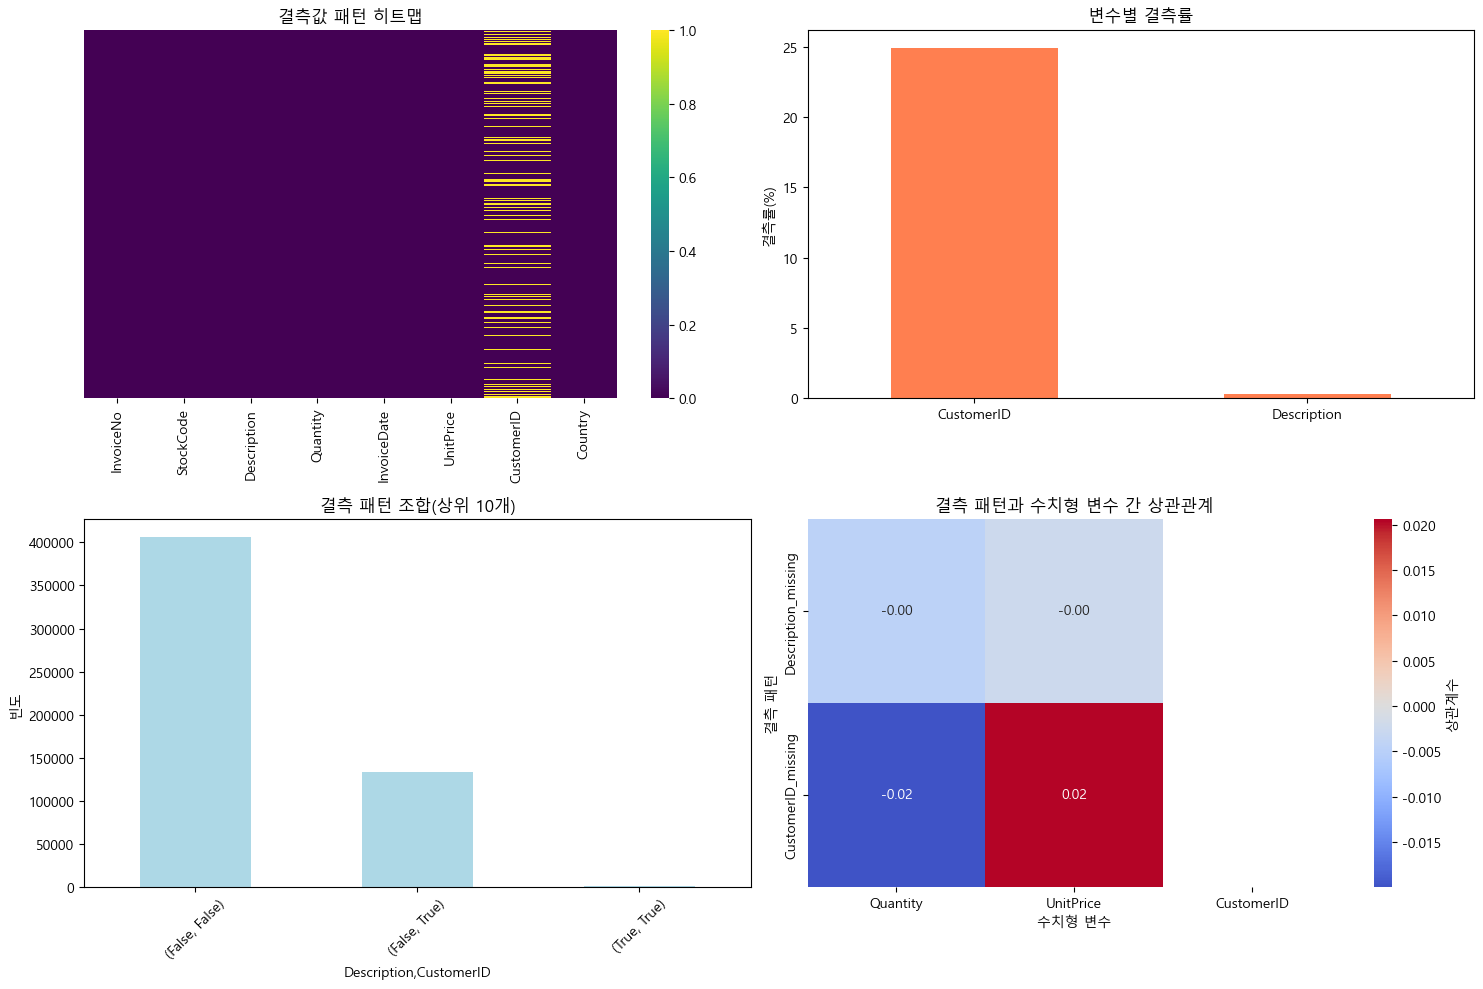

In [4]:
patterns.analyze_missing_patterns(df)

In [5]:
# 결측치 처리 후 실행하기
outlier.outlier_detection(df)

결측치 확인, 제거 후 다시 실행해주세요


In [6]:
# 데이터 체크
print(df.info())
print('전체 거래', len(df))
print('고유 InvoiceNo', df['InvoiceNo'].nunique())
print('고유 고객수', df['CustomerID'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
전체 거래 541909
고유 InvoiceNo 25900
고유 고객수 4372


In [7]:
# 데이터 전처리
df_clean = df.copy()

# CustomerID 없는 경우 아예 삭제
missing_customers = df_clean['CustomerID'].isnull().sum()
df_clean = df_clean.dropna(subset=['CustomerID'])
print(f'CustomerID 결측값 제거: {missing_customers}건')

# 파생변수 생성 및 데이터 정리 - TotalAmount, InvoiceDate(DateTime), Year, Month, DayOfWeek(str), Hour, DayName(str), CustomerID(str)
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
df_clean['DayName'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int).astype(str)

# 취소거래 분리(InvoiceNO가 C로 시작)
cancel_mask = df_clean['InvoiceNo'].astype('str').str.startswith('C')
df_cancel = df_clean[cancel_mask]  # 취소거래
df_clean = df_clean[~cancel_mask]  # 정상거래
print(f'취소거래 분리: 취소 {len(df_cancel)}건 / 정상 {len(df_clean)}건')

print('\n=== 이상값 확인 ===')
print(f'음수 수량: {(df_clean['Quantity'] < 0).sum()}')
print(f'음수 단가: {(df_clean['UnitPrice'] < 0).sum()}')
print(f'단가가 0: {(df_clean['UnitPrice'] == 0).sum()}')
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# display(df_clean.info())
display(df_clean.head())

CustomerID 결측값 제거: 135080건
취소거래 분리: 취소 8905건 / 정상 397924건

=== 이상값 확인 ===
음수 수량: 0
음수 단가: 0
단가가 0: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Year,Month,DayOfWeek,Hour,DayName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,2,8,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,2,8,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,2,8,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,2,8,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,2,8,Wednesday


In [8]:
print('=== 고객별 구매 패턴 특성 DF 생성 ===')

customer_stats = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # 구매 횟수
    'Quantity': ['sum', 'mean'],  # 총구매량, 평균구매량
    'UnitPrice': 'mean',  # 평균 단가
    'TotalAmount': ['sum', 'mean'],  # 총구매액, 평균구매액
    'StockCode': 'nunique',  # 구매한 상품 종류 수
    'InvoiceDate': ['min', 'max'],  # 첫 구매일, 마지막 구매일
}).round(2)

# 컬럼명 정리(구매횟수==Frequency, 총구매액==Monetary)
customer_stats.columns = ['구매횟수', '총구매량', '평균구매량', '평균단가', 
                        '총구매액', '평균구매액', '상품종류수', '첫구매일', '마지막구매일']

# 구매 기간 및 주기 계산(추가)
customer_stats['구매기간일수'] = (customer_stats['마지막구매일'] - customer_stats['첫구매일']).dt.days + 1
customer_stats['구매주기'] = customer_stats['구매기간일수'] / customer_stats['구매횟수']
analysis_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
customer_stats['최근성'] = (analysis_date - customer_stats['마지막구매일']).dt.days

# RFM 분석 변수
customer_stats['Recency'] = customer_stats['최근성']
customer_stats['Frequency'] = customer_stats['구매횟수']
customer_stats['Monetary'] = customer_stats['총구매량']

# RFM 점수(.qcut으로 5등분)
customer_stats['R_score'] = pd.qcut(customer_stats['Recency'], 5, labels=[5, 4, 3, 2, 1])
customer_stats['F_score'] = pd.qcut(customer_stats['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
customer_stats['M_score'] = pd.qcut(customer_stats['Monetary'], 5, labels=[5, 4, 3, 2, 1])
customer_stats['RFM_score'] = customer_stats['R_score'].astype(str) + customer_stats['F_score'].astype(str) + customer_stats['M_score'].astype(str)

# 추가정보
customer_stats['평균장바구니크기'] = customer_stats['총구매량'] / customer_stats['구매횟수']
customer_stats['거래당상품종류'] = customer_stats['상품종류수'] / customer_stats['구매횟수']

# 가격 민감도 = 단가가 얼마나 일관적인가
# CV(Coefficient of Variation): 표준편차 / 평균 -> 낮을수록 평균에 비해 편차가 작다 = 특정 가격대를 고정적으로 구매함
price_cv = df_clean.groupby('CustomerID')['UnitPrice'].agg(['mean','std'])
price_cv['가격변동성'] = (price_cv['std'] / price_cv['mean']).fillna(0)
customer_stats = customer_stats.merge(
    price_cv[['가격변동성']],  # 두 DF 다 컬럼이 아닌 인덱스가 CustomerID임 
    left_index=True,  # customer_stats의 인덱스 기준으로 병함
    right_index=True  # price_cv의 인덱스 기준으로 병함
)

customer_stats.head()

=== 고객별 구매 패턴 특성 DF 생성 ===


,구매횟수,총구매량,평균구매량,평균단가,총구매액,평균구매액,상품종류수,첫구매일,마지막구매일,구매기간일수,...,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,평균장바구니크기,거래당상품종류,가격변동성
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,1,74215,74215.00,1.04,77183.60,77183.60,1,2011-01-18 10:01:00,2011-01-18 10:01:00,1,...,326,1,74215,1,1,1,111,74215.000000,1.000000,0.000000
12347,7,2458,13.51,2.64,4310.00,23.68,103,2010-12-07 14:57:00,2011-12-07 15:52:00,366,...,2,7,2458,5,5,1,551,351.142857,14.714286,0.853015
12348,4,2341,75.52,5.76,1797.24,57.98,22,2010-12-16 19:09:00,2011-09-25 13:13:00,283,...,75,4,2341,2,4,1,241,585.250000,5.500000,2.324492
12349,1,631,8.64,8.29,1757.55,24.08,73,2011-11-21 09:51:00,2011-11-21 09:51:00,1,...,19,1,631,4,1,2,412,631.000000,73.000000,4.225823
12350,1,197,11.59,3.84,334.40,19.67,17,2011-02-02 16:01:00,2011-02-02 16:01:00,1,...,310,1,197,1,1,4,114,197.000000,17.000000,2.430180


In [9]:
print('=== 기본 상관관계 분석 ===')

# 수치형 상관관계
numeric_cols =  ['평균구매량', '평균단가', '총구매액', '총구매량',
                '평균구매액', '상품종류수', '구매기간일수', '구매주기', '최근성', 
                '구매횟수', '평균장바구니크기', '거래당상품종류', '가격변동성']

correlation_data = customer_stats[numeric_cols]
correlation_data.head(3)

=== 기본 상관관계 분석 ===


,평균구매량,평균단가,총구매액,총구매량,평균구매액,상품종류수,구매기간일수,구매주기,최근성,구매횟수,평균장바구니크기,거래당상품종류,가격변동성
CustomerID,,,,,,,,,,,,,
12346,74215.00,1.04,77183.60,74215,77183.60,1,1,1.000000,326,1,74215.000000,1.000000,0.000000
12347,13.51,2.64,4310.00,2458,23.68,103,366,52.285714,2,7,351.142857,14.714286,0.853015
12348,75.52,5.76,1797.24,2341,57.98,22,283,70.750000,75,4,585.250000,5.500000,2.324492


In [10]:
# 상관관계

# 피어슨(실제 데이터를 그대로 사용): 키/몸무게, 온도/전력 같이 실제 값 자체가 비례하는 경우 사용
pearson_corr = correlation_data.corr(method='pearson')

# 스피어맨(서열형 데이터): 시험순위/대회순위, 만족도/구매의사 처럼 순위에 상관관계가 있을 때 사용 - 너무 스케일이 벌어진 데이터도 같은 상관관계로 볼수 있게 함
# 두 변수의 순위 값 사이의 피어슨 상관계수
spearman_corr = correlation_data.corr(method='spearman')

# 켄달
kendall_corr = correlation_data.corr(method='kendall')

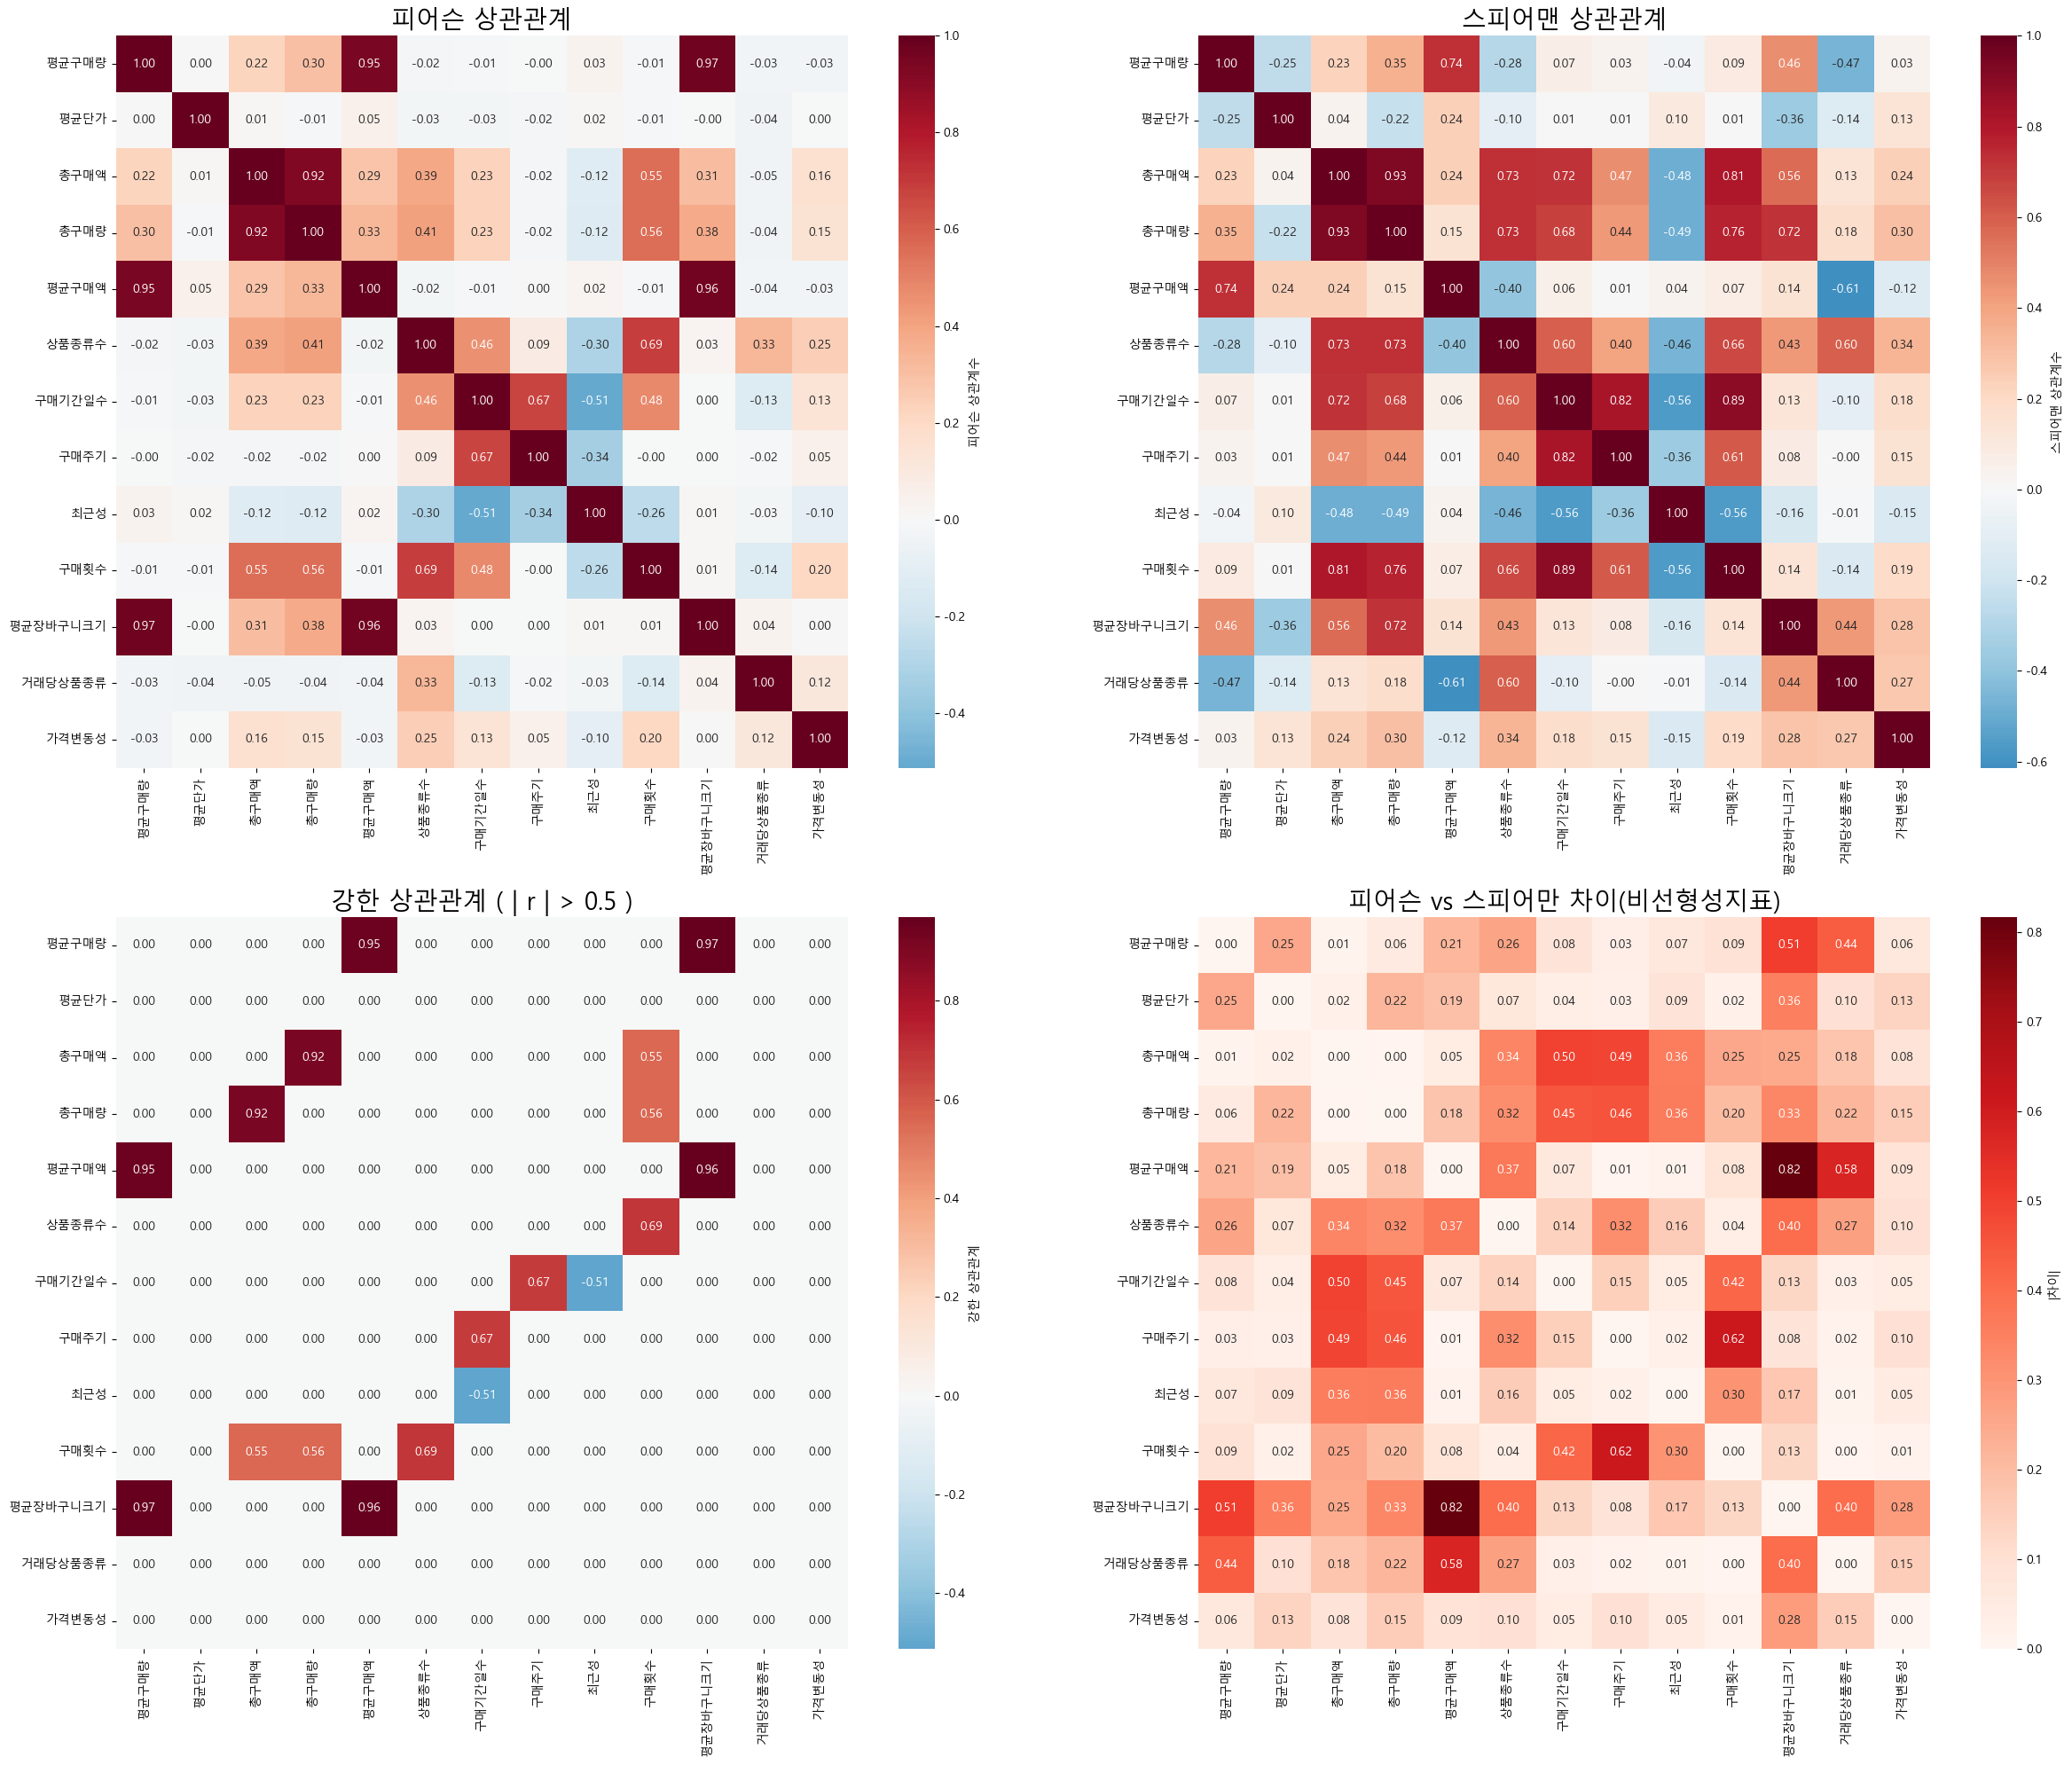

In [11]:
fig, axes = plt.subplots(2, 2, figsize = (25, 20))
a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# 피어슨 - 선형 관계
sns.heatmap(
    pearson_corr,
    ax=a1,
    annot=True,
    cmap='RdBu_r',
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={'label': '피어슨 상관계수'}
)
a1.set_title('피어슨 상관관계', fontsize=20)

# 스피어맨 - 순위 기반
sns.heatmap(
    spearman_corr,
    ax=a2,
    annot=True,
    cmap='RdBu_r',
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={'label': '스피어맨 상관계수'}
)
a2.set_title('스피어맨 상관관계', fontsize=20)

# 강한 상관관계 (|r| > 0.5)
strong_corr = pearson_corr.copy()
strong_corr[abs(strong_corr) < 0.5] = 0
np.fill_diagonal(strong_corr.values,0)

sns.heatmap(
    strong_corr,
    ax=a3,
    annot=True,
    cmap='RdBu_r',
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={'label': '강한 상관관계'}
)
a3.set_title('강한 상관관계 ( | r | > 0.5 )', fontsize=20)

# 스피어맨-피어슨 차이
# 여기서 진하게 나올수록 선형 데이터가 아니라는 것
corr_diff = abs(spearman_corr - pearson_corr)
sns.heatmap(
    corr_diff, 
    annot=True, 
    fmt='.2f', 
    cmap='Reds',
    square=True, 
    ax=a4, 
    cbar_kws={'label': '|차이|'}
)
a4.set_title('피어슨 vs 스피어만 차이(비선형성지표)', fontsize=20)


plt.tight_layout()
plt.show()

In [12]:
# 주요 발견사항 요약
print('\n=== 주요 상관관계 발견사항 ===')
upper_triangle = np.triu(pearson_corr, k=1)  # 위쪽 삼각행렬
strong_positive = np.unravel_index(np.argmax(upper_triangle), upper_triangle.shape)  # 그 중에서 가장 큰 값이 있는 인덱스
max_corr = pearson_corr.iloc[strong_positive]
print('\n가장 강한 양의 상관관계:')
print(f'  {pearson_corr.index[strong_positive[0]]} <-> {pearson_corr.index[strong_positive[1]]}, r = {max_corr:.3f}')

strong_negative = np.unravel_index(np.argmin(upper_triangle), upper_triangle.shape)
min_corr = pearson_corr.iloc[strong_negative]

print('\n가장 강한 음의 상관관계:')
print(f'  {pearson_corr.index[strong_negative[0]]} <-> {pearson_corr.index[strong_negative[1]]}, r = {min_corr:.3f}')


=== 주요 상관관계 발견사항 ===

가장 강한 양의 상관관계:
  평균구매량 <-> 평균장바구니크기, r = 0.970

가장 강한 음의 상관관계:
  구매기간일수 <-> 최근성, r = -0.514


In [13]:
print('매출 증대 핵심 요인')
monetary_corr = pearson_corr['총구매액'].abs().sort_values(ascending=False)
for factor, corr in monetary_corr.head(6).items():
    if factor != '총구매액':
        print(f'  {factor}: {corr:.3f}')

print('\n고객 충성도 관련 요인')
frequency_corr = pearson_corr['구매횟수'].abs().sort_values(ascending=False)
for factor, corr in frequency_corr.head(6).items():
    if factor != '구매횟수':
        print(f'  {factor}: {corr:.3f}')

매출 증대 핵심 요인
  총구매량: 0.923
  구매횟수: 0.554
  상품종류수: 0.387
  평균장바구니크기: 0.310
  평균구매액: 0.287

고객 충성도 관련 요인
  상품종류수: 0.692
  총구매량: 0.558
  총구매액: 0.554
  구매기간일수: 0.477
  최근성: 0.261


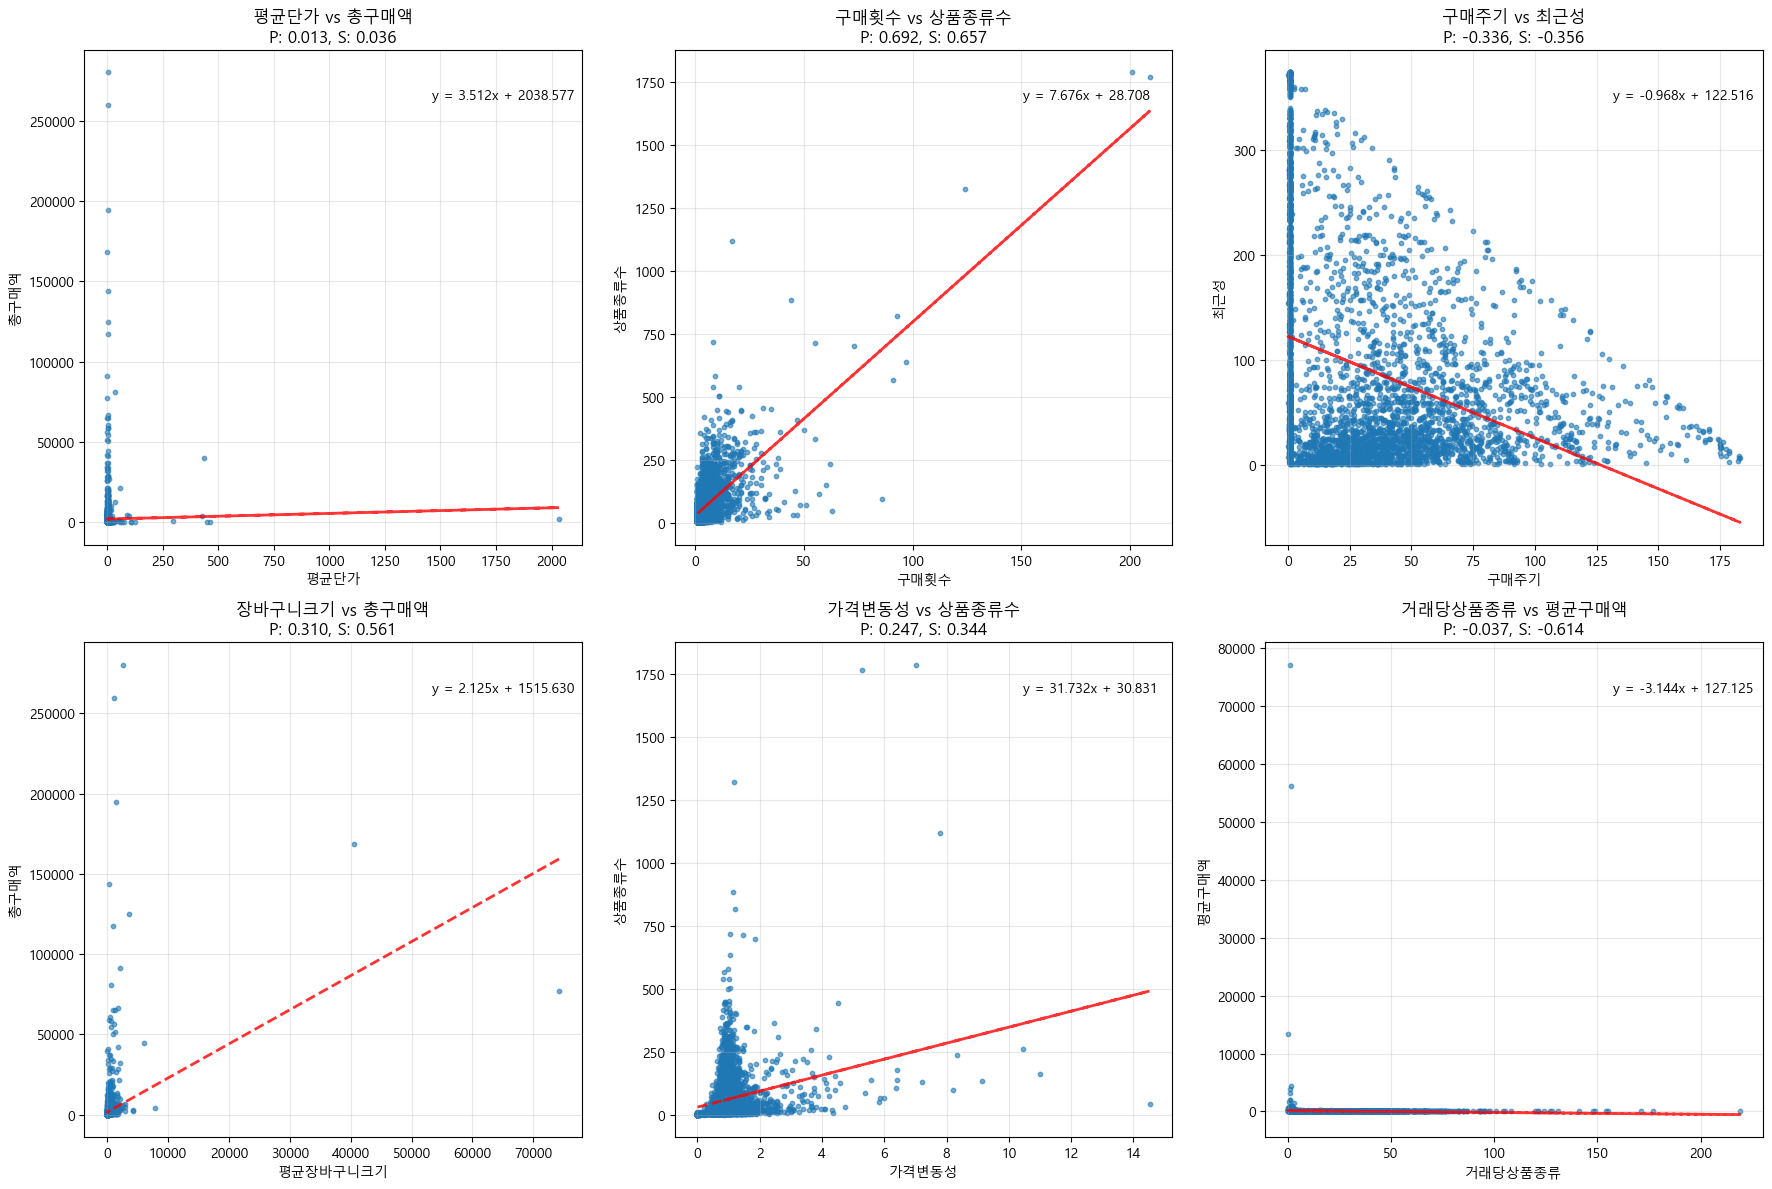

In [14]:
# 비선형 관계
fig, axes = plt.subplots(2, 3, figsize = (18, 12))
axes = axes.ravel()  # 2차원 axes 배열을 평탄화

relationships = [
    ('평균단가', '총구매액', '평균단가 vs 총구매액'),
    ('구매횟수', '상품종류수', '구매횟수 vs 상품종류수'),
    ('구매주기', '최근성', '구매주기 vs 최근성'), 
    ('평균장바구니크기', '총구매액', '장바구니크기 vs 총구매액'),
    ('가격변동성', '상품종류수', '가격변동성 vs 상품종류수'),
    ('거래당상품종류', '평균구매액', '거래당상품종류 vs 평균구매액')
]

for idx, (x, y, title) in enumerate(relationships):
    # 산점도 그래프 그리기
    axes[idx].scatter(customer_stats[x], customer_stats[y], alpha=0.6, s=10)  # scatter() = 산점도, s는 점 크기/alpha는 투명도
    
    # 선형 회귀선 그리기(트렌드라인)
    z = np.polyfit(customer_stats[x], customer_stats[y], 1)  # x, y를 가지고 만들수 있는 n차함수(각 계수를 어레이에 넣어준다)
    p = np.poly1d(z)  # p는 z(기울기, y절편)를 기반으로 한 1차함수(poly1d니까)
    axes[idx].plot(customer_stats[x], p(customer_stats[x]), 'r--', alpha=0.8, linewidth=2)  # x, p(x)에 대한 그래프 그리기
    
    pearson_r = customer_stats[x].corr(customer_stats[y])
    spearman_r = customer_stats[x].corr(customer_stats[y], method='spearman')
    
    axes[idx].set_xlabel(x)
    axes[idx].set_ylabel(y)
    axes[idx].text(0.7, 0.9, f'y = {z[0]:.3f}x + {z[1]:.3f}', transform=axes[idx].transAxes)
    axes[idx].set_title(f'{title}\nP: {pearson_r:.3f}, S: {spearman_r:.3f}')
    axes[idx].grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

In [15]:
# 고급 상관관계 측정
from scipy.stats import kendalltau

print('=== 고급 상관관계 측정 ===')
key_vars = ['총구매액', '구매횟수', '최근성', '평균단가', '상품종류수', '평균장바구니크기']
analysis_data = customer_stats[key_vars]


# 켄달 타우 상관계수 - 이상치에 조금 더 강함(계산시 이상치를 좀 배제하고 나온다), 순위 기반, 조건부 상관관계도 확인 가능
    # 보통 데이터 개수가 적거나 순위정보만 확실한 경우 / 데이터에 이상치가 있거나 동점자가 많은 경우 사용함(같은 순위기반이지만 스피어만은 연속형/비선형 데이터일 때 사용함)
    # 해당 변수의 정보를 확실하게 할 수 있을 때 그때그때 구분하면 됨
print('1. 켄달 타우 상관계수 분석')
kendall_results = {}
for idx, var1 in enumerate(key_vars):
    for var2 in key_vars[idx+1:]:
        # 일반적인 corr -> 타우값만 주고, p-value는 주지 않는다
        # tau = analysis_data[var1].corr(analysis_data[var2], method='kendall')
        tau, p_value = kendalltau(analysis_data[var1], analysis_data[var2])
        if p_value < 0.05 and abs(tau) > 0.2:
            # 결과 확인 - 유의미한 관계(p_value < 0.05)만
            kendall_results[f'{var1} vs {var2}'] = {'tau': tau, 'p_value': p_value}

for rel, stats in kendall_results.items():
    print(f'  {rel} = {stats['tau']:.3f}, (p={stats['p_value']:.3f})')

=== 고급 상관관계 측정 ===
1. 켄달 타우 상관계수 분석
  총구매액 vs 구매횟수 = 0.657, (p=0.000)
  총구매액 vs 최근성 = -0.335, (p=0.000)
  총구매액 vs 상품종류수 = 0.555, (p=0.000)
  총구매액 vs 평균장바구니크기 = 0.396, (p=0.000)
  구매횟수 vs 최근성 = -0.425, (p=0.000)
  구매횟수 vs 상품종류수 = 0.505, (p=0.000)
  최근성 vs 상품종류수 = -0.318, (p=0.000)
  평균단가 vs 평균장바구니크기 = -0.251, (p=0.000)
  상품종류수 vs 평균장바구니크기 = 0.300, (p=0.000)


In [16]:
# 상호 정보량(Mutual Information) 기반 분석

# 선형, 비선형 구분없이 변수간 정보량 공유 정도 측정
# MI = 0 -> 전혀 관련 없다
# MI > 1 -> 꽤 관련 있음
# MI가 많이 큼 -> 변수 X는 변수 Y 예측에 유용함

# 켄달 타우: 방향과 순위의 일관성
# MI 점수: 관계가 있긴 한데, 관계가 +인지 -인지는 상관 없고, 둘이 얼마나 강하게 연결되어있는지만 알려줌

# 두 변수가 서로 독립변수인지 구분할 때 사용한다.

from sklearn.feature_selection import mutual_info_regression
print('2. 상호 정보량 기반 연관성(총구매액 기준)')

target = analysis_data['총구매액']
features = analysis_data.drop('총구매액', axis=1)
mi_scores = mutual_info_regression(features, target, random_state=42)
mi_results = pd.DataFrame({
    'feature': features.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

for _, row in mi_results.iterrows():
    print(f'  {row['feature']}: {row['MI_Score']:.3f}')

2. 상호 정보량 기반 연관성(총구매액 기준)
  구매횟수: 0.554
  상품종류수: 0.516
  평균장바구니크기: 0.237
  최근성: 0.138
  평균단가: 0.057


In [19]:
# 조건부 상관관계 분석 - 고객 세그먼트별
print('3. 조건부 상관관계 분석 - 고객 세그먼트별')
customer_stats['Segment'] = 'Regular'

vip_mask = (
    (customer_stats['R_score'].astype(int) >= 4) &
    (customer_stats['F_score'].astype(int) >= 4) &
    (customer_stats['M_score'].astype(int) >= 4)
)
customer_stats.loc[vip_mask, 'Segment'] = 'VIP'

new_mask = customer_stats['Frequency'] == 1
customer_stats.loc[new_mask, 'Segment'] = 'New'

segments = ['VIP', 'New', 'Regular']
segment_corrs = {}

for seg in segments:
    seg_data = customer_stats[customer_stats['Segment'] == seg]
    if len(seg_data) > 10:
        corr = seg_data['상품종류수'].corr(seg_data['Monetary'])  # 세그먼트 별로 상품종류수와 Monetary의 관계를 보겠다
        segment_corrs[seg] = {
            'corr': corr,
            'size': len(seg_data)
        }
    print(f'  {seg}고객: M - 상품종류수 = {corr:.3f} (n = {len(seg_data)})')
customer_stats.head()

3. 조건부 상관관계 분석 - 고객 세그먼트별
  VIP고객: M - 상품종류수 = 0.437 (n = 56)
  New고객: M - 상품종류수 = 0.034 (n = 1493)
  Regular고객: M - 상품종류수 = 0.405 (n = 2789)


,구매횟수,총구매량,평균구매량,평균단가,총구매액,평균구매액,상품종류수,첫구매일,마지막구매일,구매기간일수,...,Frequency,Monetary,R_score,F_score,M_score,RFM_score,평균장바구니크기,거래당상품종류,가격변동성,Segment
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,1,74215,74215.00,1.04,77183.60,77183.60,1,2011-01-18 10:01:00,2011-01-18 10:01:00,1,...,1,74215,1,1,1,111,74215.000000,1.000000,0.000000,New
12347,7,2458,13.51,2.64,4310.00,23.68,103,2010-12-07 14:57:00,2011-12-07 15:52:00,366,...,7,2458,5,5,1,551,351.142857,14.714286,0.853015,Regular
12348,4,2341,75.52,5.76,1797.24,57.98,22,2010-12-16 19:09:00,2011-09-25 13:13:00,283,...,4,2341,2,4,1,241,585.250000,5.500000,2.324492,Regular
12349,1,631,8.64,8.29,1757.55,24.08,73,2011-11-21 09:51:00,2011-11-21 09:51:00,1,...,1,631,4,1,2,412,631.000000,73.000000,4.225823,New
12350,1,197,11.59,3.84,334.40,19.67,17,2011-02-02 16:01:00,2011-02-02 16:01:00,1,...,1,197,1,1,4,114,197.000000,17.000000,2.430180,New


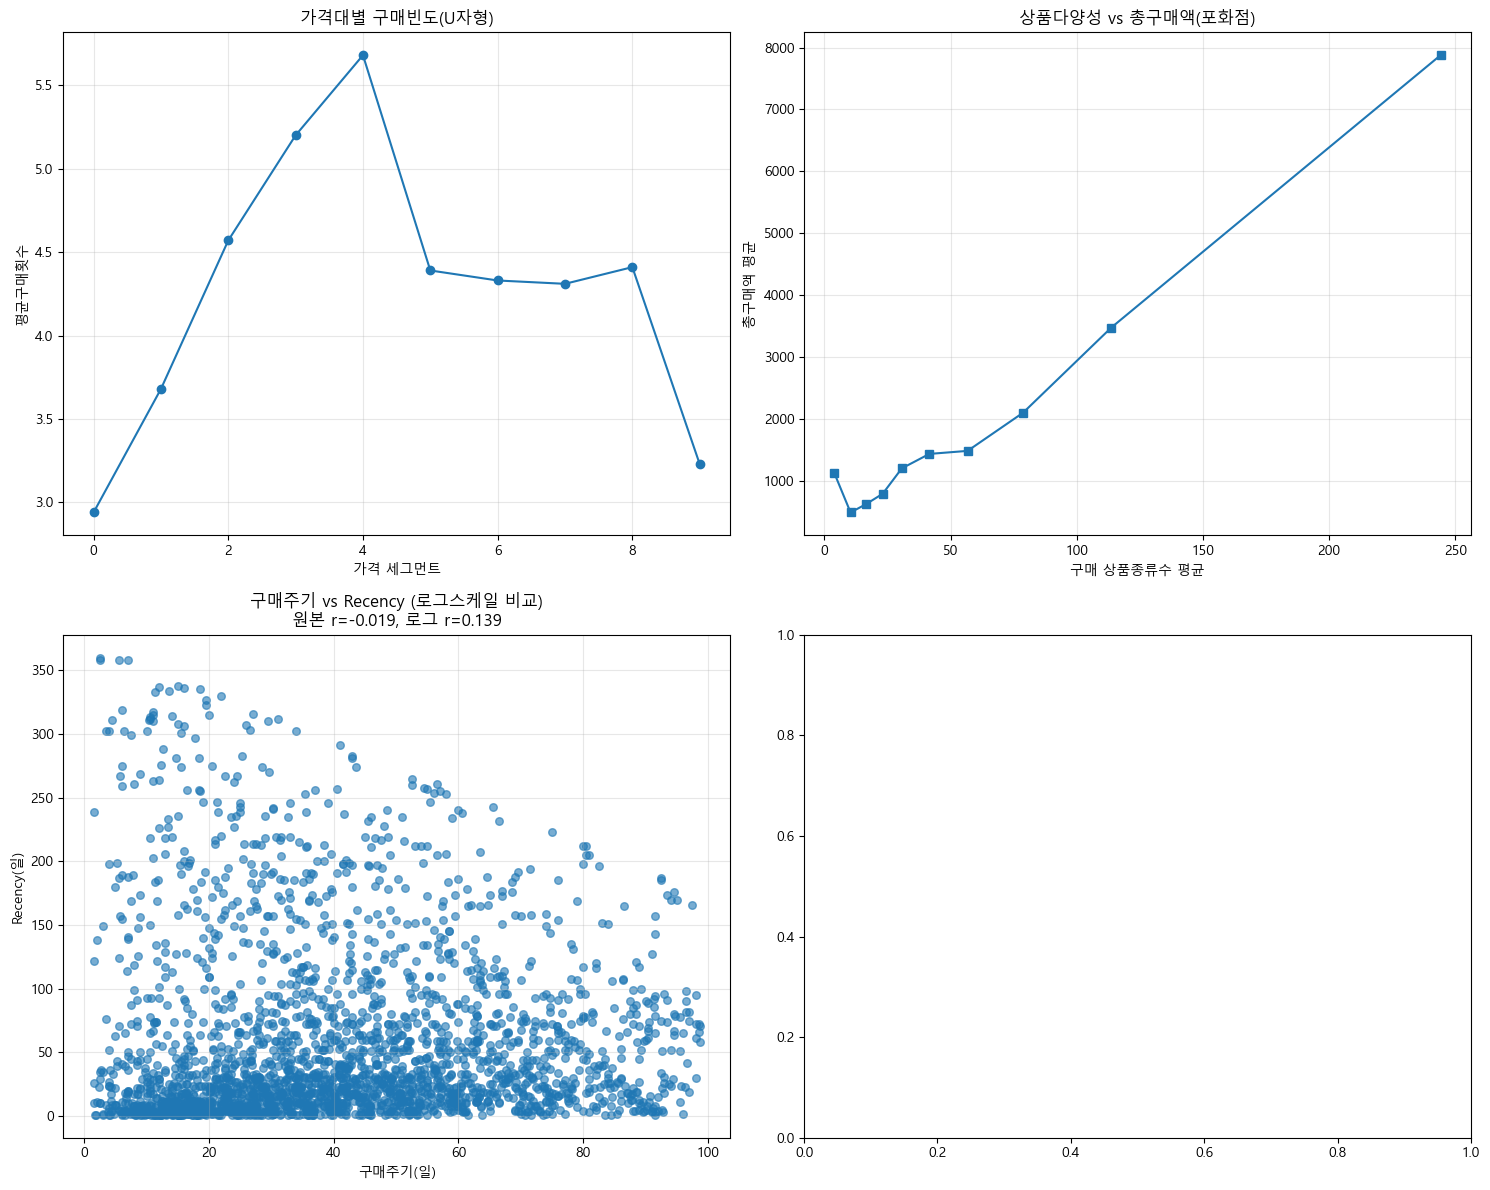

In [ ]:
# 비선형 패턴 심화

fig, axes = plt.subplots(2, 2, figsize = (15, 12))
a1, a2, a3, a4 = axes.ravel()

# 1. 평균단가 구간 별 구매횟수 분석
customer_stats['Price_Segment'] = pd.qcut(customer_stats['평균단가'], q=10, labels=False, duplicates='drop')
price_freq_analysis = customer_stats.groupby('Price_Segment').agg({
    '구매횟수': ['mean', 'count'],
    '평균단가': 'mean',
    '총구매액': 'mean',
}).round(2)
price_freq_analysis.columns = ['평균구매횟수','고객수','평균단가','평균총구매액']
# display(price_freq_analysis)

a1.plot(price_freq_analysis.index, price_freq_analysis['평균구매횟수'], marker='o')
a1.set_xlabel('가격 세그먼트')
a1.set_ylabel('평균구매횟수')
a1.set_title('가격대별 구매빈도(U자형)')
a1.grid(True, alpha=0.3)
# 가격대별 구매빈도는 U자형임(가운데가 높고, 옆으로 갈수록 낮아짐) -> 분명 관계가 있음

# 2. 구매 상품 다양성 vs 총구매액
customer_stats['Variety_Segment'] = pd.qcut(customer_stats['상품종류수'], q=10, labels=False, duplicates='drop')
variety_analysis = customer_stats.groupby('Variety_Segment').agg({
    '총구매액': 'mean',
    '평균구매액': 'mean',
    '상품종류수': 'mean',
}).round(2)
# display(variety_analysis)

a2.plot(variety_analysis['상품종류수'], variety_analysis['총구매액'], marker='s')
a2.set_xlabel('구매 상품종류수 평균')
a2.set_ylabel('총구매액 평균')
a2.set_title('상품다양성 vs 총구매액(포화점)')
a2.grid(True, alpha=0.3)
# 포화점 - 상품종류수가 늘어나도 구매액이 더 안늘어나는 구간(기울기가 어느 수준 이상부터는 완만해진다는 것)

# 3. 구매주기와 recency의 관계
valid_cycle = customer_stats[(customer_stats['구매주기'] < customer_stats['구매주기'].quantile(0.95)) & (customer_stats['구매주기'] > 1)]
a3.scatter(valid_cycle['구매주기'], valid_cycle['Recency'], alpha=0.6, s=30)
a3.set_xlabel('구매주기(일)')
a3.set_ylabel('Recency(일)')
a3.grid(True, alpha=0.3)

# 로그변환으로 상관계수 확인
log_cycle = np.log1p(valid_cycle['구매주기'])
log_recency = np.log1p(valid_cycle['Recency'])

original_corr = valid_cycle['구매주기'].corr(valid_cycle['Recency'])
log_corr = log_cycle.corr(log_recency)

a3.set_title(f'구매주기 vs Recency (로그스케일 비교)\n원본 r={original_corr:.3f}, 로그 r={log_corr:.3f}')

# 4. 가격변동성 vs 상품변동성



plt.tight_layout()
plt.show()

### 범주형 데이터 분석

In [127]:
print('=== 범주형 데이터 연관성 분석 ===')

print('1. 국가별 구매 패턴 분석')
# 구매 횟수 많은 상위 10개국
country_counts = df_clean['Country'].value_counts().head(10)
major_countries = country_counts.index.to_list()
df_major = df_clean[df_clean['Country'].isin(major_countries)].copy()

# 국가별 집계 분석
country_analysis = df_major.groupby('Country').agg({
    'TotalAmount': ['sum', 'mean', 'count'],
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'CustomerID': 'nunique'
}).round(2)

country_analysis.columns = ['총매출', '평균거래액', '거래수', '평균수량', '평균단가', '고객수']
country_analysis['고객당매출'] = (country_analysis['총매출'] / country_analysis['고객수']).round(2)
print('주요 국가별 구매 지표')
display(country_analysis.sort_values('총매출', ascending=False))

# 2. 시간대별 구매 패턴 분석
print('\n2. 시간대별 구매 패턴 분석')
hourly_analysis = df_clean.groupby('Hour').agg({
    'TotalAmount': ['sum', 'mean', 'count'],
    'CustomerID': 'nunique'
}).round(2)
hourly_analysis.columns = ['총매출', '평균거래액', '거래수', '고객수']
display(hourly_analysis)

peak_hours = hourly_analysis.nlargest(3, '거래수')
print('거래량 상위 3개 시간대')
for hour in peak_hours.index:
    print(f'  {hour}시: {peak_hours.loc[hour, '거래수']}건')
    
# 3. 요일별 구매 패턴 분석

print('\n3. 요일별 구매 패턴 분석')
daily_analysis = df_clean.groupby('DayName').agg({
    'TotalAmount': ['sum', 'mean'],
    'CustomerID': 'nunique'
}).round(2)
daily_analysis.columns = ['총매출', '평균거래액', '고객수']

# 요일 순서 정렬
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_analysis = daily_analysis.reindex(weekday_order)
display(daily_analysis)

peak_days = daily_analysis.nlargest(3, '총매출')
print('매출 상위 3개 요일')
for day in peak_days.index:
    print(f'  {day}: {peak_days.loc[day, '총매출']}$')


=== 범주형 데이터 연관성 분석 ===
1. 국가별 구매 패턴 분석
주요 국가별 구매 지표


,총매출,평균거래액,거래수,평균수량,평균단가,고객수,고객당매출
Country,,,,,,,
United Kingdom,7308391.55,20.63,354321,12.01,2.96,3920,1864.39
Netherlands,285446.34,121.00,2359,84.93,2.65,9,31716.26
EIRE,265545.90,36.70,7236,19.39,4.45,3,88515.30
Germany,228867.14,25.32,9040,13.19,3.71,94,2434.76
France,209024.05,25.06,8341,13.36,4.42,87,2402.58
Australia,138521.31,117.19,1182,70.98,3.06,9,15391.26
Spain,61577.11,24.79,2484,11.25,3.83,30,2052.57
Switzerland,56443.95,30.66,1841,16.34,3.47,21,2687.81
Belgium,41196.34,20.28,2031,11.44,3.63,25,1647.85



2. 시간대별 구매 패턴 분석


,총매출,평균거래액,거래수,고객수
Hour,,,,
6,4.25,4.25,1,1
7,31059.21,81.95,379,28
8,282115.63,32.46,8690,427
9,842605.17,38.40,21944,890
10,1261192.57,33.19,37997,1268
11,1104558.75,22.50,49084,1303
12,1378571.48,19.13,72065,1637
13,1173264.75,18.32,64026,1573
14,995629.37,18.40,54118,1386


거래량 상위 3개 시간대
  12시: 72065건
  13시: 64026건
  14시: 54118건

3. 요일별 구매 패턴 분석


,총매출,평균거래액,고객수
DayName,,,
Monday,1367146.41,21.07,1595.0
Tuesday,1700634.63,25.58,1701.0
Wednesday,1588336.17,23.06,1778.0
Thursday,1976859.07,24.70,2007.0
Friday,1485917.40,27.10,1557.0
Saturday,NaN,NaN,NaN
Sunday,792514.22,12.63,1225.0


매출 상위 3개 요일
  Thursday: 1976859.07$
  Tuesday: 1700634.63$
  Wednesday: 1588336.17$


### 카이제곱 검정과 Cramer's V

=== 카이제곱 검정 & Cramer's V 분석 ===


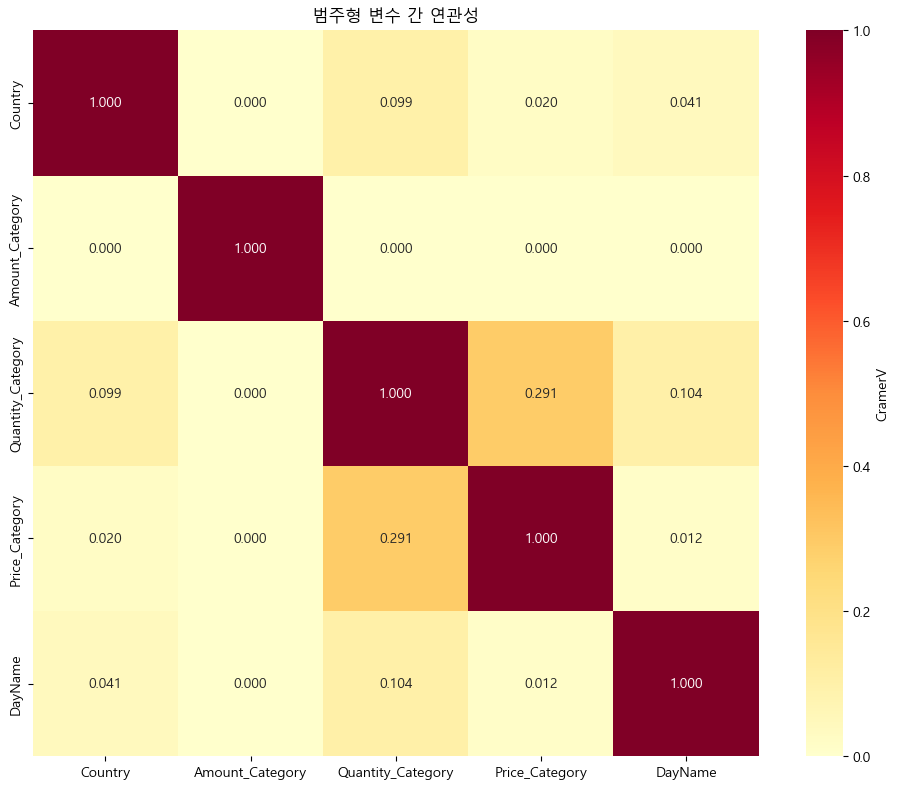

   Quantity_Category ↔ Price_Category: 0.291

가장 강한 연관성 상세 분석: Quantity_Category vs Price_Category
교차표 (행 기준 백분율):


Price_Category,저가,중가,고가
Quantity_Category,,,
소,24.0,34.2,41.8
중,23.8,45.4,30.8
대,61.5,31.6,6.9



카이제곱 검정 결과:
   카이제곱 통계량: 64584.349
   p-value: 0.000000
   자유도: 4
   결론: 유의한 연관성 있음 (α=0.05)


In [137]:
# 카이제곱 검정(우연인지 아닌지)과 Cramer's V(연관성의 강도) 분석
# 범주형 데이터에서만 사용 가능하다
from scipy.stats import chi2_contingency

print('=== 카이제곱 검정 & Cramer\'s V 분석 ===')

df_analysis = df_major.copy()

# 범주형 변수로 변환

# 거래액 구간화
df_analysis['Amount_Cateogry'] = pd.qcut(df_analysis['TotalAmount'], q=4, labels=['저액', '중저액', '중고액', '고액'])
# 수량 구간화
df_analysis['Quantity_Category'] = pd.qcut(df_analysis['Quantity'], q=3, labels=['소', '중', '대'])
# 단가 구간화
df_analysis['Price_Category'] = pd.qcut(df_analysis['UnitPrice'], q=3, labels=['저가', '중가', '고가'])

# 크레머-v 계산기
def cramers_v(x, y):
    """Cramér's V 계산"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 카테고리형 변수
categorical_vars = ['Country', 'Amount_Category', 'Quantity_Category', 'Price_Category', 'DayName']

# 분석효율을 위해 5개만 선택
top_5_countries = df_analysis['Country'].value_counts().head(5).index
df_analysis = df_analysis[df_analysis['Country'].isin(top_5_countries)]

# Cramér's V 매트릭스 계산
cramers_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

for var1 in categorical_vars:
    for var2 in categorical_vars:
        if var1 == var2:
            cramers_matrix.loc[var1, var2] = 1.0
        else:
            try:
                cramers_matrix.loc[var1, var2] = cramers_v(df_analysis[var1], df_analysis[var2])
            except:
                cramers_matrix.loc[var1, var2] = 0.0

cramers_matrix = cramers_matrix.astype(float)

# Cramer 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, fmt='.3f', cmap='YlOrRd', square=True, cbar_kws={'label': 'CramerV'})
plt.title('범주형 변수 간 연관성')
plt.tight_layout()
plt.show()

upper_triangle = np.triu(cramers_matrix.values, k=1)
strong_associations = []

strong_associations = []
for i in range(len(categorical_vars)):
    for j in range(i+1, len(categorical_vars)):
        if upper_triangle[i, j] > 0.2:  # 중간 이상 연관성
            strong_associations.append({
                'var1': categorical_vars[i],
                'var2': categorical_vars[j], 
                'cramers_v': upper_triangle[i, j]
            })

strong_associations.sort(key=lambda x: x['cramers_v'], reverse=True)

for assoc in strong_associations:
    print(f"   {assoc['var1']} ↔ {assoc['var2']}: {assoc['cramers_v']:.3f}")

# 5. 교차표 분석 (가장 강한 연관성)
if strong_associations:
    strongest = strong_associations[0]
    print(f"\n가장 강한 연관성 상세 분석: {strongest['var1']} vs {strongest['var2']}")
    
    crosstab = pd.crosstab(df_analysis[strongest['var1']], 
                            df_analysis[strongest['var2']], 
                            normalize='index') * 100
    
    print("교차표 (행 기준 백분율):")
    display(crosstab.round(1))
    
    # 카이제곱 검정
    chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(df_analysis[strongest['var1']], 
                                                                df_analysis[strongest['var2']]))
    
    print(f"\n카이제곱 검정 결과:")
    print(f"   카이제곱 통계량: {chi2:.3f}")
    print(f"   p-value: {p_value:.6f}")
    print(f"   자유도: {dof}")
    print(f"   결론: {'유의한 연관성 있음' if p_value < 0.05 else '연관성 없음'} (α=0.05)")

### ANOVA 분석

In [139]:
# 개념
import pandas as pd
import numpy as np
from scipy import stats

# 예시 데이터 생성
np.random.seed(42)
df = pd.DataFrame({
    '그룹': np.repeat(['A', 'B', 'C'], 10),
    '점수': np.concatenate([
        np.random.normal(70, 5, 10),  # A반 평균 70, 표준편차 5
        np.random.normal(75, 5, 10),  # B반 평균 75
        np.random.normal(80, 5, 10)   # C반 평균 80
    ])
})

# -----------------------------
# 1. ANOVA (Analysis of Variance, 분산분석)
# -----------------------------
# - 범주형(그룹)과 수치형(점수) 관계에서
#   각 그룹의 평균이 통계적으로 차이가 있는지 확인
# - 귀무가설(H0): 모든 그룹 평균은 같다
# - 대립가설(H1): 적어도 한 그룹 평균이 다르다
# - 결과: p값이 0.05보다 작으면 → "차이가 있다"라고 판단
# -----------------------------
groups = [df[df['그룹'] == g]['점수'] for g in df['그룹'].unique()]
f_stat, p_value = stats.f_oneway(*groups)

print("ANOVA 결과")
print(f"F-통계량: {f_stat:.3f}")
print(f"p-값: {p_value:.4f}")  # 0.05보다 작으면 유의미한 차이

# -----------------------------
# 2. 상관비 (Correlation Ratio, η²)
# -----------------------------
# - 범주형 변수가 수치형 변수를 얼마나 설명하는지 (0~1 사이)
# - 계산식: η² = 집단간 분산(SSB) / 전체 분산(SST)
# - 0 → 전혀 설명 못함, 1 → 완벽히 설명
# -----------------------------
def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    grand_mean = values.mean()
    
    # 집단간 제곱합 SSB
    ssb = sum([
        len(values[categories == cat]) * (values[categories == cat].mean() - grand_mean) ** 2
        for cat in np.unique(categories)
    ])
    # 전체 제곱합 SST
    sst = sum((values - grand_mean) ** 2)
    
    return ssb / sst

eta_squared = correlation_ratio(df['그룹'], df['점수'])

print("\n상관비 결과")
print(f"η² (Eta Squared): {eta_squared:.3f}")  # 0.01~0.06: 약함, 0.06~0.14: 중간, 0.14 이상: 강함


ANOVA 결과
F-통계량: 12.210
p-값: 0.0002

상관비 결과
η² (Eta Squared): 0.475


=== 혼합형 데이터 연관성 분석 ===
국가별 구매 특성 차이 분석 (일원분산분석):
   Monetary: F = 0.129, p = 0.9719 
   Frequency: F = 0.403, p = 0.8065 
   평균단가: F = 0.005, p = 1.0000 
   상품종류수: F = 0.262, p = 0.9022 
   Recency: F = 0.670, p = 0.6129 

 범주형-수치형 연관성 (상관비 η²):
   Country → Monetary: η² = 0.000
   Country → Frequency: η² = 0.000
   Country → 평균단가: η² = 0.000
   Country → 상품종류수: η² = 0.000
   Country → Recency: η² = 0.001


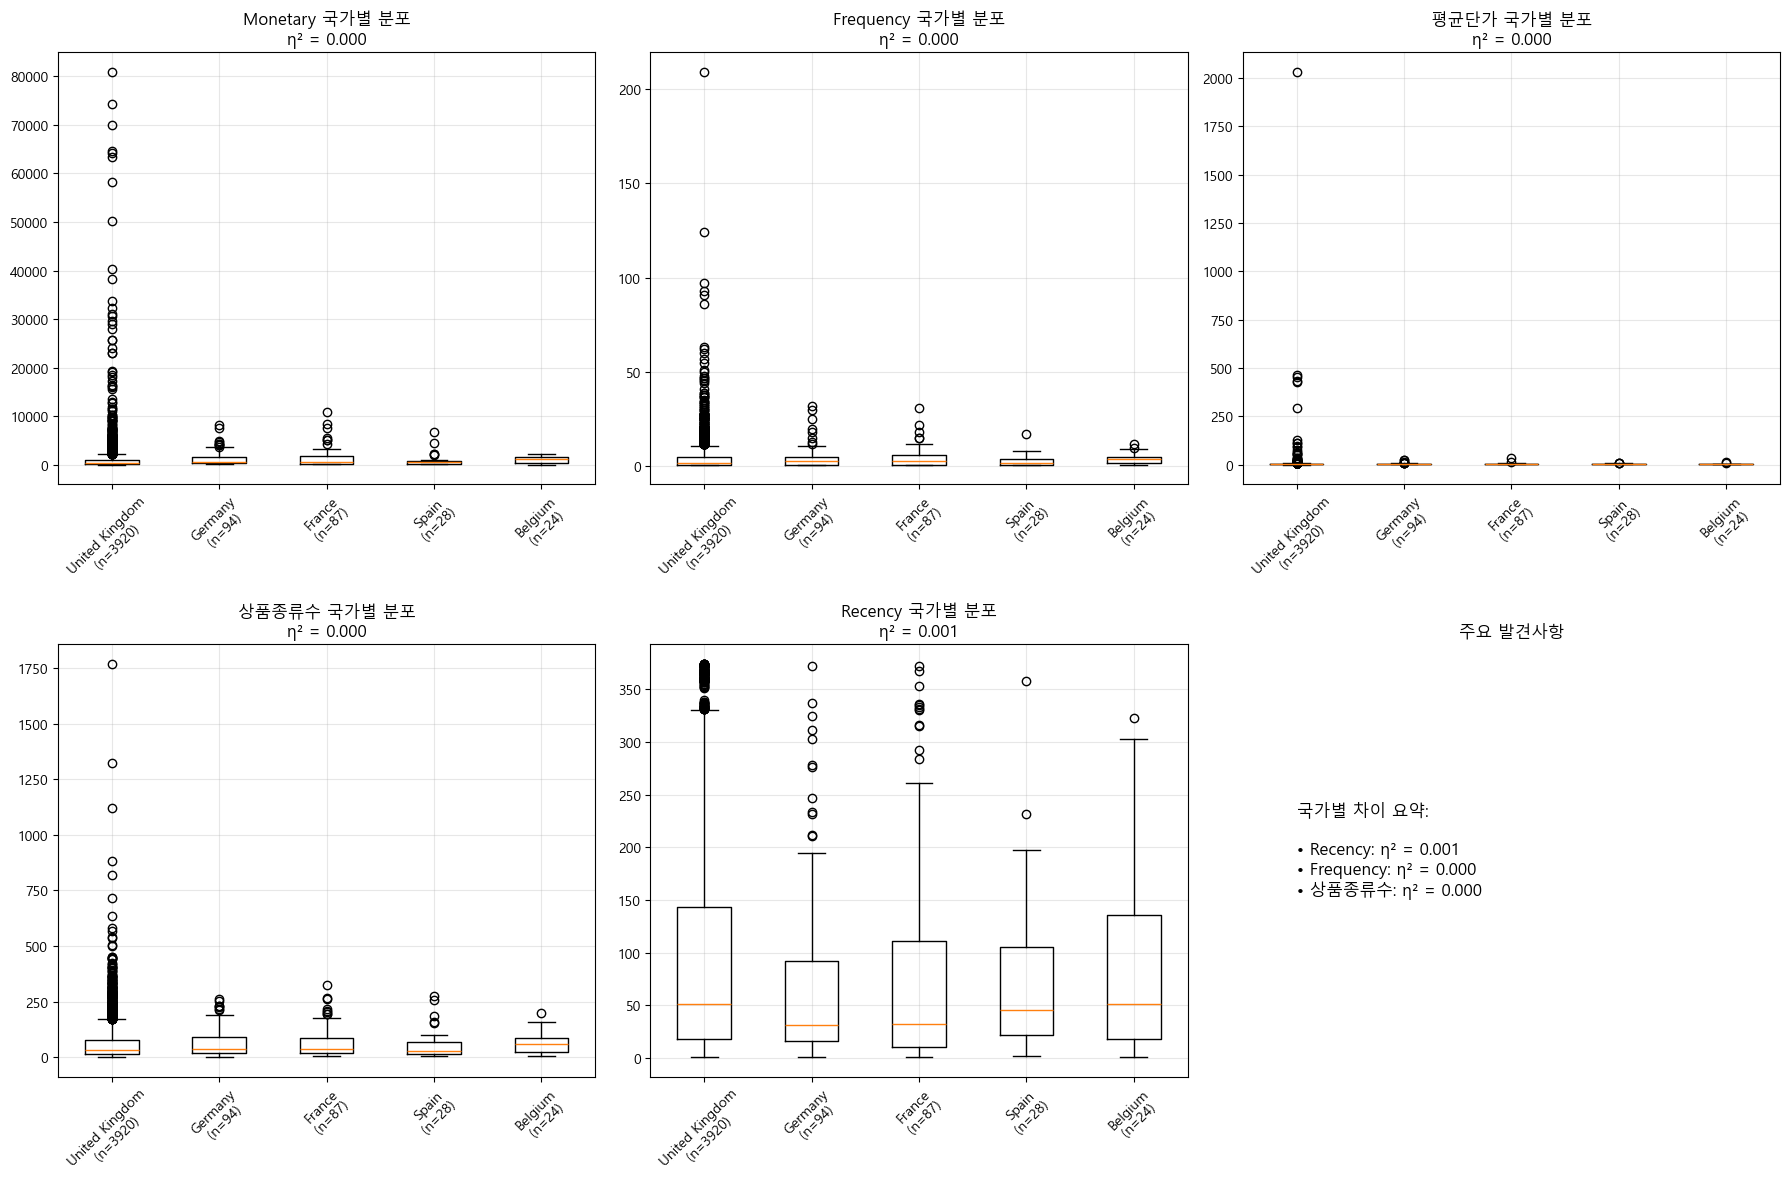


3. 국가별 구매 패턴 비즈니스 인사이트:
   Monetary:
     최고: France (1,281)
     최저: Spain (968)
   평균단가:
     최고: United Kingdom (4)
     최저: Belgium (4)
   상품종류수:
     최고: Germany (68)
     최저: United Kingdom (61)


In [138]:
# 실제 적용
print("=== 혼합형 데이터 연관성 분석 ===")

# ----------------------------------------------------
# 1. 고객 데이터에 '국가' 정보 붙이기
# ----------------------------------------------------
# 고객별 첫 번째 국가값을 가져오기
customer_country = df_clean.groupby('CustomerID')['Country'].first()

# 기존 고객 통계 데이터(customer_stats)에 국가정보를 병합
customer_features_mixed = customer_stats.merge(customer_country, 
                                               left_index=True, right_index=True)

# 상위 5개 국가만 필터링 (표본 수 적은 국가는 분석에서 제외)
top_countries = customer_country.value_counts().head(5).index
customer_features_mixed = customer_features_mixed[
    customer_features_mixed['Country'].isin(top_countries)
]

# ----------------------------------------------------
# 2. 국가별 수치형 변수 차이 분석 (일원분산분석, ANOVA)
# ----------------------------------------------------
print("국가별 구매 특성 차이 분석 (일원분산분석):")

from scipy.stats import f_oneway

# 분석할 수치형 변수 목록
numeric_vars = ['Monetary', 'Frequency', '평균단가', '상품종류수', 'Recency']

anova_results = {}

for var in numeric_vars:
    # 국가별 데이터를 그룹 리스트로 생성
    groups = [customer_features_mixed[
                  customer_features_mixed['Country'] == country
              ][var] for country in top_countries]
    
    # ANOVA 검정 (국가별 평균 차이 있는지 확인)
    f_stat, p_value = f_oneway(*groups)
    anova_results[var] = {'f_stat': f_stat, 'p_value': p_value}
    
    # p-value 유의성 표시 (***: 매우 유의, **: 유의, *: 약간 유의)
    significance = "***" if p_value < 0.001 else \
                   "**" if p_value < 0.01 else \
                   "*" if p_value < 0.05 else ""
    
    print(f"   {var}: F = {f_stat:.3f}, p = {p_value:.4f} {significance}")

# ----------------------------------------------------
# 3. 범주형(국가) ↔ 수치형 변수 상관비(η²) 계산
# ----------------------------------------------------
print(f"\n 범주형-수치형 연관성 (상관비 η²):")

def correlation_ratio(categories, values):
    """
    상관비(η²) 계산
    - categories: 범주형 데이터 (예: 국가)
    - values: 수치형 데이터 (예: 평균단가)
    - η² 값이 0이면 연관성 없음, 1이면 완전한 연관성
    """
    # 범주형을 숫자로 변환
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1  # 범주 개수
    
    # 각 범주의 평균과 개수를 저장할 배열
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    
    for i in range(cat_num):
        cat_measures = values[fcat == i]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    
    # 전체 평균
    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    
    # 분산 계산 (Between-group / Total)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg) ** 2)  # 그룹 간 분산
    denominator = np.sum((values - y_total_avg) ** 2)               # 전체 분산
    
    eta = 0 if denominator == 0 else np.sqrt(numerator / denominator)
    return eta ** 2  # η² 반환

# 국가와 수치형 변수 간 η² 계산
eta_squared_results = {}
for var in numeric_vars:
    eta_sq = correlation_ratio(customer_features_mixed['Country'], 
                                customer_features_mixed[var])
    eta_squared_results[var] = eta_sq
    print(f"   Country → {var}: η² = {eta_sq:.3f}")

# ----------------------------------------------------
# 4. 시각화 - 국가별 수치형 변수 분포 비교
# ----------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, var in enumerate(numeric_vars):
    if i < len(axes):
        data_for_plot = []
        labels_for_plot = []
        
        # 각 국가별 박스플롯 데이터 구성
        for country in top_countries:
            country_data = customer_features_mixed[
                customer_features_mixed['Country'] == country
            ][var]
            data_for_plot.append(country_data)
            labels_for_plot.append(f"{country}\n(n={len(country_data)})")
        
        axes[i].boxplot(data_for_plot, labels=labels_for_plot)
        axes[i].set_title(f'{var} 국가별 분포\nη² = {eta_squared_results[var]:.3f}')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

# 마지막 빈 그래프에 요약 텍스트 추가
if len(axes) > len(numeric_vars):
    axes[-1].axis('off')
    summary_text = "국가별 차이 요약:\n\n"
    
    # η² 값이 큰 순서대로 정렬
    sorted_eta = sorted(eta_squared_results.items(), key=lambda x: x[1], reverse=True)
    
    for var, eta_sq in sorted_eta[:3]:
        summary_text += f"• {var}: η² = {eta_sq:.3f}\n"
    
    axes[-1].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center')
    axes[-1].set_title('주요 발견사항')

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 5. 비즈니스 인사이트 출력
# ----------------------------------------------------
print(f"\n3. 국가별 구매 패턴 비즈니스 인사이트:")

# 국가별 평균값 계산
country_summary = customer_features_mixed.groupby('Country')[numeric_vars].mean().round(2)

# 주요 지표에서 최고/최저 국가 찾기
for var in ['Monetary', '평균단가', '상품종류수']:
    max_country = country_summary[var].idxmax()
    min_country = country_summary[var].idxmin()
    
    print(f"   {var}:")
    print(f"     최고: {max_country} ({country_summary.loc[max_country, var]:,.0f})")
    print(f"     최저: {min_country} ({country_summary.loc[min_country, var]:,.0f})")